In [1]:
#!pip install tensorflow[and-cuda]
#!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 16.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 12.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [43]:
#!pip install pandas
#!pip install networkx
#!pip install matplotlib
#!pip install scikit-learn

In [44]:
import pandas as pd
from keras.src.layers import Bidirectional

from component_module import drop_static_columns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# for keras tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

import matplotlib.pyplot as plt
import numpy as np
from time import time
import os
import shutil

In [45]:
# Check if TensorFlow is built with CUDA support
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available")
    print(f"Device: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print("CUDA is not available")

CUDA is available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



df = pd.read_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT DataSWaT 2015-12-23.csv")

#df.head()
df,  dropped_cols= drop_static_columns(df)
# convert time to seconds since midnight
# Convert 'Timestamp' column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['time_in_seconds'] = (df['Timestamp'].dt.hour * 3600 + df['Timestamp'].dt.minute * 60 + df['Timestamp'].dt.second)              
df.set_index('time_in_seconds', inplace=True)
df.drop(columns=['Timestamp', 'time'], inplace=True)

# normalised data
scaler = StandardScaler()
df_normalised = scaler.fit_transform(df)
# convert back to df
df_normalised = pd.DataFrame(df_normalised, columns=df.columns)
df_normalised.to_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT_2015_12_23_for_tf.csv",index=False)



In [60]:

#df = pd.read_csv("/home/loz/MSc/MSc_Project/SWaT_2015_12_23_for_tf.csv")
df = pd.read_csv("/home/loz/Documents/GitHub/MSc-Project/SWaT_12_23_sec_minmax.csv", index_col='time_in_seconds')

In [61]:
df.shape

(86400, 37)

In [62]:
df.head()

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,P602
time_in_seconds,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.990606,0.5,1.0,1.000000,0.128753,0.498588,0.769136,1.0,0.0,...,0.686274,0.56685,0.541283,0.429823,0.344541,0.390927,0.238806,0.402412,0.0,0.0
1,0.0,0.989536,0.5,1.0,1.000000,0.128753,0.499496,0.863706,1.0,1.0,...,0.686274,0.56685,0.421003,0.429823,0.546218,0.382286,0.238806,0.402412,0.0,0.0
2,0.0,0.989536,0.5,1.0,1.000000,0.128753,0.501614,0.916761,1.0,1.0,...,0.686274,0.56685,0.408771,0.429823,0.546218,0.360690,0.238806,0.400006,0.0,0.0
3,0.0,0.989417,0.5,1.0,0.966105,0.125893,0.504035,0.952045,1.0,1.0,...,0.686274,0.56685,0.460754,0.622810,0.546218,0.360690,0.238806,0.378318,0.0,0.0
4,0.0,0.988585,0.5,1.0,0.966105,0.125893,0.507466,0.974452,1.0,1.0,...,0.686274,0.56685,0.580023,0.622810,0.546218,0.388771,0.238806,0.378318,0.0,0.0


In [63]:
component_map = list(df.columns)
len(component_map)

37

In [64]:
# check data is in time order
#df.sort_values(by='time_in_seconds', inplace=True)

In [65]:
df_test = df
df_test.shape

(86400, 37)

In [66]:
#df_test.set_index('time_in_seconds', inplace=True)
data_array = df_test.to_numpy()




In [67]:
# shape of array
data_array.shape

(86400, 37)

In [68]:
# dataset in single slices of array so 1 second rows
#dataset.element_spec

In [132]:
# Window size in seconds
window_size = 20
# Define batch of windows to process in parallel before updating weights 
batch_size = 32


def windowed_dataset(data_array, window_size, batch_size):
    '''
    get full dataset as np array
    :param series: 
    :param window_size: 
    :param batch_size: 
    :return: 
    '''
    
    # Create a TensorFlow dataset from the NumPy array
    dataset = tf.data.Dataset.from_tensor_slices(data_array)

    # Window the dataset into n second long slices with a 1 sec shift between each
    dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
    
    # Flatten the windowed dataset for input layer
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Split window into features and labels (last row)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    
    # batch 
    dataset = dataset.batch(batch_size)
    
    # set indefinite repeat to allow looping back through
    #dataset = dataset.repeat()
    
    return dataset
    
    

In [133]:
split_time = int(data_array.shape[0] * 0.8)
train_dataset = data_array[:split_time]
val_dataset = data_array[split_time:]
train_dataset.shape
val_dataset.shape

(17280, 37)

In [134]:
train_dataset = windowed_dataset(train_dataset, window_size, batch_size)
val_dataset = windowed_dataset(val_dataset, window_size, batch_size)

In [135]:
# Check the first window
for features, label in train_dataset.take(1):
    print("Features shape: ", features.shape)  # Should be (19, 37)
    print("Label shape: ", label.shape)        # Should be (37,)

Features shape:  (32, 19, 37)
Label shape:  (32, 1, 37)


In [136]:
# Count the number of windows
num_windows = train_dataset.reduce(0, lambda x, _: x + 1).numpy() * batch_size


print(f"Number of windows: {num_windows}")

Number of windows: 69120


# split data
train_size = int(0.8 * num_windows)
train_dataset = windowed_dataset.take(train_size)
val_dataset = windowed_dataset.skip(train_size)

# batch data
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [137]:
for feature, lable in train_dataset.take((1)):
    print(feature.numpy().shape)

(32, 19, 37)


2024-09-26 16:41:31.425771: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [139]:
(window_size - 1, data_array.shape[1])

(19, 37)

# Hyperparameter Optimisation



In [140]:
# Directory for model performance logs
LOG_DIR = os.path.join("my_tuner_logs")

In [141]:
BI_LOG_DIR = os.path.join("my_bi_tuner_logs")

In [142]:
def build_model():
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    
   
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add an LSTM layer with 50 units (neurons) and 
    model.add(LSTM(50))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=0.00005)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    # Print model summary
    model.summary()
    
    # epochs is number of times to iterate through whole dataset
    epochs = 10
    
    batch_size = 32
    # floor steps per epoch calculated to avoid error
    steps_per_epoch = num_windows // batch_size 
    
    return model #, epochs, steps_per_epoch



In [143]:
def build_bi_model():
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    
    
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add bidirectional LSTM layer with 50 units (neurons) 
    model.add(Bidirectional(LSTM(50)))
       
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=0.00005)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    # Print model summary
    model.summary()
    
    # epochs is number of times to iterate through whole dataset
    epochs = 10
    
    batch_size = 32
    
    # floor steps per epoch calculated to avoid error
    steps_per_epoch = num_windows // batch_size 
    
    return model #, epochs, steps_per_epoch



In [144]:
def build_model_tuner(hp):
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    

    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Range of LSTM units for tuner
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=16)
    # Add an LSTM layer with tuner range 
    model.add(LSTM(units=lstm_units))
    
    # Tune the number of units in the dense layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=16)
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG')
    
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model #, epochs, steps_per_epoch



In [145]:
def build_bi_model_tuner(hp):
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    

    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Range of LSTM units for tuner
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=16)
    # Add an bidirectional LSTM layer with tuner range 
    model.add(Bidirectional(LSTM(units=lstm_units)))
    
    # Tune the number of units in the dense layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=16)
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG')
    
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    
    return model #, epochs, steps_per_epoch



In [146]:
def build_best_model(tuner):
    '''
    Function to build model based on hyper parameters 
    
    params:
    params_dict: params returned from tuner including lstm, dense layer and learning rate
     
    returns: 
    model: Keras model
    
    '''
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    lstm_units = best_hps.values['lstm_units']
    dense_units = best_hps.values['dense_units']
    learning_rate = best_hps.values['learning_rate']

    # Define the model
    model = Sequential()
    
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add an LSTM layer with best number of units (neurons)
    model.add(LSTM(lstm_units))
    
    # add dense layer
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model



In [147]:
def build_best_bi_model(bi_tuner):
    '''
    Function to build model based on hyper parameters 
    
    params:
    params_dict: params returned from tuner including lstm, dense layer and learning rate
     
    returns: 
    model: Keras model
    
    '''
    best_hps = bi_tuner.get_best_hyperparameters(num_trials=1)[0]
    
    lstm_units = best_hps.values['lstm_units']
    dense_units = best_hps.values['dense_units']
    learning_rate = best_hps.values['learning_rate']

    # Define the model
    model = Sequential()
    
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add bidirectional LSTM layer with 50 units (neurons) 
    model.add(Bidirectional(LSTM(lstm_units)))
    
    # add dense layer
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model



In [148]:
LOG_DIR

'my_tuner_logs'

In [149]:
# Clear logs to run tuner from scratch
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)  # Deletes the directory and its contents


# keras tuner to find optimum model
tuner = RandomSearch(build_model_tuner,
                     objective = "val_loss",
                     max_trials = 5,
                     executions_per_trial = 1,
                     directory = LOG_DIR,
                     project_name = "lstm_all_data"
                     )

In [150]:
# Clear logs to run tuner from scratch
if os.path.exists(BI_LOG_DIR):
    shutil.rmtree(BI_LOG_DIR)  # Deletes the directory and its contents
    
# keras tuner to find optimum model
bi_tuner = RandomSearch(build_bi_model_tuner,
                     objective = "val_loss",
                     max_trials = 5,
                     executions_per_trial = 1,
                     directory = BI_LOG_DIR,
                     project_name = "lstm_all_data"
                     )

## Tuner Version

In [151]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the tuner
tuner.search(
    train_dataset,  # Pass your windowed and batched training dataset
    epochs=10,
    validation_data=val_dataset,  # Pass your windowed and batched validation dataset
    callbacks=[early_stop]
)

Trial 5 Complete [00h 01m 00s]
val_loss: 0.008566572330892086

Best val_loss So Far: 0.008566572330892086
Total elapsed time: 00h 04m 41s


early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the tuner
bi_tuner.search(
    train_dataset,  # Pass your windowed and batched training dataset
    epochs=10,
    validation_data=val_dataset,  # Pass your windowed and batched validation dataset
    callbacks=[early_stop]
)

In [152]:
# Best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Best hyperparameters:
lstm_units: 80
dense_units: 96
learning_rate: 2.8082945698622538e-05


5.164419548491746e-05

In [154]:
# Best model
best_simple_model = tuner.get_best_models(num_models=1)[0]
best_simple_model.summary()

/home/loz/Documents/GitHub/MSc-Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80)             │        37,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │         7,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         3,589 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,125 (191.89 KB)

 Trainable params: 49,125 (191.89 KB)

 Non-trainable params: 0 (0.00 B)

In [155]:
# Rebuild the model and load weights from the best model
best_simple_model = build_best_model(tuner)

In [156]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
best_history = best_simple_model.fit(
    train_dataset,
    epochs=40,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

Epoch 1/40
   2146/Unknown 6s 2ms/step - loss: 0.1255 - mae: 0.2447

/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1250 - mae: 0.2441 - val_loss: 0.0190 - val_mae: 0.0931
Epoch 2/40
  65/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0876 - mae: 0.2017

2024-09-26 16:49:41.584060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:49:41.584100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:49:41.584113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2148/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255 - mae: 0.1053

2024-09-26 16:49:46.732920: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:49:46.732949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0254 - mae: 0.1051 - val_loss: 0.0129 - val_mae: 0.0735
Epoch 3/40
  59/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0582 - mae: 0.1627

2024-09-26 16:49:47.544077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:49:47.544122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:49:47.544135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2142/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - mae: 0.0851

2024-09-26 16:49:53.276719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:49:53.276752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0168 - mae: 0.0850 - val_loss: 0.0115 - val_mae: 0.0689
Epoch 4/40
2145/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - mae: 0.0734

2024-09-26 16:49:59.364215: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1894060704157194119
2024-09-26 16:49:59.364259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:49:59.364267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:49:59.364276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0128 - mae: 0.0733 - val_loss: 0.0108 - val_mae: 0.0658
Epoch 5/40
  60/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0315 - mae: 0.1249

2024-09-26 16:50:00.061802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:50:00.061847: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:50:00.061867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2151/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - mae: 0.0659

2024-09-26 16:50:06.040674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0105 - mae: 0.0658 - val_loss: 0.0106 - val_mae: 0.0637
Epoch 6/40
  49/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0268 - mae: 0.1154

2024-09-26 16:50:06.990131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:50:06.990187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:50:06.990199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2147/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - mae: 0.0604

2024-09-26 16:50:13.640950: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1894060704157194119
2024-09-26 16:50:13.640979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:50:13.640988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:50:13.640997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0090 - mae: 0.0604 - val_loss: 0.0104 - val_mae: 0.0627
Epoch 7/40
  59/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0224 - mae: 0.1031

2024-09-26 16:50:14.393089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:50:14.393120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:50:14.393131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2143/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - mae: 0.0565

2024-09-26 16:50:20.255980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0081 - mae: 0.0564 - val_loss: 0.0102 - val_mae: 0.0612
Epoch 8/40
  61/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0198 - mae: 0.0953

2024-09-26 16:50:21.019130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:50:21.019156: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:50:21.019162: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2158/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - mae: 0.0527

2024-09-26 16:50:26.547025: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1894060704157194119
2024-09-26 16:50:26.547052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:50:26.547057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:50:26.547067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0073 - mae: 0.0527 - val_loss: 0.0101 - val_mae: 0.0608
Epoch 9/40
2141/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0496

2024-09-26 16:50:32.321593: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1894060704157194119
2024-09-26 16:50:32.321615: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:50:32.321619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:50:32.321627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0068 - mae: 0.0496 - val_loss: 0.0099 - val_mae: 0.0600
Epoch 10/40
  59/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0172 - mae: 0.0863

2024-09-26 16:50:32.951951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:50:32.951969: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:50:32.951975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2147/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - mae: 0.0470

2024-09-26 16:50:38.022511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0063 - mae: 0.0470 - val_loss: 0.0099 - val_mae: 0.0595
Epoch 11/40
  52/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0170 - mae: 0.0853

2024-09-26 16:50:38.737648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:50:38.737692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:50:38.737705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2148/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - mae: 0.0450

2024-09-26 16:50:44.142720: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:50:44.142771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0059 - mae: 0.0450 - val_loss: 0.0098 - val_mae: 0.0592
Epoch 12/40
  63/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0145 - mae: 0.0775

2024-09-26 16:50:44.903323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:50:44.903357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:50:44.903370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0056 - mae: 0.0431 - val_loss: 0.0098 - val_mae: 0.0591
Epoch 13/40
  57/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0137 - mae: 0.0760

2024-09-26 16:50:50.873641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:50:50.873671: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:50:50.873681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2152/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mae: 0.0416

2024-09-26 16:50:56.245201: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1894060704157194119
2024-09-26 16:50:56.245222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:50:56.245226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:50:56.245230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0053 - mae: 0.0416 - val_loss: 0.0097 - val_mae: 0.0583
Epoch 14/40
  59/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0124 - mae: 0.0726

2024-09-26 16:50:56.900138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:50:56.900178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:50:56.900191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2156/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mae: 0.0404

2024-09-26 16:51:02.384087: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1894060704157194119
2024-09-26 16:51:02.384121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:51:02.384133: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:51:02.384142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0051 - mae: 0.0404 - val_loss: 0.0094 - val_mae: 0.0573
Epoch 15/40
  53/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0119 - mae: 0.0713

2024-09-26 16:51:03.181268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:51:03.181305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:51:03.181313: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2159/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - mae: 0.0392

2024-09-26 16:51:09.081850: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14303577543200194559
2024-09-26 16:51:09.081881: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:51:09.081890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:51:09.081899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0049 - mae: 0.0392 - val_loss: 0.0092 - val_mae: 0.0564
Epoch 16/40
  51/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0111 - mae: 0.0693

2024-09-26 16:51:09.826020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:51:09.826043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:51:09.826048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2158/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0382

2024-09-26 16:51:15.720065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:51:15.720085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:51:15.720090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0048 - mae: 0.0382 - val_loss: 0.0091 - val_mae: 0.0557
Epoch 17/40
  62/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0100 - mae: 0.0646

2024-09-26 16:51:16.430338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:51:16.430368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2153/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - mae: 0.0373

2024-09-26 16:51:21.826117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0046 - mae: 0.0373 - val_loss: 0.0090 - val_mae: 0.0551
Epoch 18/40
  48/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0101 - mae: 0.0659

2024-09-26 16:51:22.647134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:51:22.647175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:51:22.647183: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2147/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - mae: 0.0365

2024-09-26 16:51:28.909631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0045 - mae: 0.0365 - val_loss: 0.0089 - val_mae: 0.0543
Epoch 19/40
  58/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0093 - mae: 0.0619

2024-09-26 16:51:29.699225: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-26 16:51:29.699256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:51:29.699261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:51:29.699265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - mae: 0.0358

2024-09-26 16:51:35.484107: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0045 - mae: 0.0358 - val_loss: 0.0087 - val_mae: 0.0536
Epoch 20/40
  61/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0089 - mae: 0.0596

2024-09-26 16:51:36.084112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:51:36.084134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2155/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - mae: 0.0351

2024-09-26 16:51:41.335753: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14303577543200194559
2024-09-26 16:51:41.335774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878
2024-09-26 16:51:41.335789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:51:41.335793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0044 - mae: 0.0351 - val_loss: 0.0086 - val_mae: 0.0528
Epoch 21/40
  56/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0087 - mae: 0.0589

2024-09-26 16:51:42.098204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:51:42.098231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:51:42.098243: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2156/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - mae: 0.0345

2024-09-26 16:51:49.111906: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:51:49.111944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:51:49.111957: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0043 - mae: 0.0345 - val_loss: 0.0085 - val_mae: 0.0523
Epoch 22/40
  57/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0083 - mae: 0.0570

2024-09-26 16:51:49.857232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:51:49.857295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:51:49.857325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2159/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - mae: 0.0339

2024-09-26 16:51:55.325200: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1894060704157194119
2024-09-26 16:51:55.325230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:51:55.325242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:51:55.325253: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0042 - mae: 0.0339 - val_loss: 0.0084 - val_mae: 0.0519
Epoch 23/40
  58/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0080 - mae: 0.0556

2024-09-26 16:51:55.968483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:51:55.968513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2157/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - mae: 0.0334

2024-09-26 16:52:02.290483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:52:02.290523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0042 - mae: 0.0334 - val_loss: 0.0084 - val_mae: 0.0516
Epoch 24/40
  58/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0076 - mae: 0.0544

2024-09-26 16:52:03.047770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:52:03.047790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:52:03.047794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2148/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0330

2024-09-26 16:52:08.550430: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14303577543200194559
2024-09-26 16:52:08.550462: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:52:08.550472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:52:08.550480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0041 - mae: 0.0329 - val_loss: 0.0083 - val_mae: 0.0513
Epoch 25/40
  61/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0072 - mae: 0.0527

2024-09-26 16:52:09.189662: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:52:09.189692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0041 - mae: 0.0325 - val_loss: 0.0082 - val_mae: 0.0510
Epoch 26/40
  56/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0069 - mae: 0.0524

2024-09-26 16:52:15.431111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:52:15.431133: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:52:15.431138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0040 - mae: 0.0321 - val_loss: 0.0080 - val_mae: 0.0507
Epoch 27/40
  49/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0067 - mae: 0.0526

2024-09-26 16:52:21.961216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:52:21.961252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:52:21.961265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2155/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - mae: 0.0318

2024-09-26 16:52:28.457719: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1894060704157194119
2024-09-26 16:52:28.457751: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:52:28.457761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:52:28.457769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0040 - mae: 0.0318 - val_loss: 0.0079 - val_mae: 0.0504
Epoch 28/40
  63/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0062 - mae: 0.0493

2024-09-26 16:52:29.225004: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:52:29.225039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:52:29.225053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2153/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mae: 0.0314

2024-09-26 16:52:34.983824: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1894060704157194119
2024-09-26 16:52:34.983854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:52:34.983863: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:52:34.983871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0039 - mae: 0.0314 - val_loss: 0.0078 - val_mae: 0.0502
Epoch 29/40
  53/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0060 - mae: 0.0497

2024-09-26 16:52:35.618277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:52:35.618309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0039 - mae: 0.0311 - val_loss: 0.0076 - val_mae: 0.0499
Epoch 30/40
  65/2160 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0057 - mae: 0.0470

2024-09-26 16:52:41.217586: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:52:41.217609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:52:41.217613: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0038 - mae: 0.0308 - val_loss: 0.0075 - val_mae: 0.0496
Epoch 31/40
  69/2160 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0054 - mae: 0.0457

2024-09-26 16:52:46.968461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:52:46.968481: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:52:46.968487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2157/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0305

2024-09-26 16:52:52.990174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:52:52.990215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0038 - mae: 0.0305 - val_loss: 0.0073 - val_mae: 0.0493
Epoch 32/40
  50/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0053 - mae: 0.0473

2024-09-26 16:52:53.786820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:52:53.786854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2153/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0303

2024-09-26 16:53:00.432680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:53:00.432715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0038 - mae: 0.0302 - val_loss: 0.0072 - val_mae: 0.0492
Epoch 33/40
  54/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0051 - mae: 0.0459

2024-09-26 16:53:01.234101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:53:01.234144: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:53:01.234158: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2152/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0300

2024-09-26 16:53:07.351700: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0037 - mae: 0.0300 - val_loss: 0.0071 - val_mae: 0.0490
Epoch 34/40
  62/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0050 - mae: 0.0441

2024-09-26 16:53:07.977541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:53:07.977563: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:53:07.977570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2150/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0297

2024-09-26 16:53:13.556526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0037 - mae: 0.0297 - val_loss: 0.0070 - val_mae: 0.0488
Epoch 35/40
  58/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0048 - mae: 0.0438

2024-09-26 16:53:14.209596: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:53:14.209634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2138/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - mae: 0.0295

2024-09-26 16:53:19.409347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0037 - mae: 0.0294 - val_loss: 0.0068 - val_mae: 0.0486
Epoch 36/40
  58/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0047 - mae: 0.0431

2024-09-26 16:53:20.030942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:53:20.030981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2158/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0292

2024-09-26 16:53:26.471986: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0037 - mae: 0.0292 - val_loss: 0.0067 - val_mae: 0.0483
Epoch 37/40
  42/2160 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0045 - mae: 0.0443

2024-09-26 16:53:27.618601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:53:27.618639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2159/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0290

2024-09-26 16:53:34.216159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:53:34.216200: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:53:34.216213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0036 - mae: 0.0290 - val_loss: 0.0066 - val_mae: 0.0479
Epoch 38/40
  48/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0045 - mae: 0.0428

2024-09-26 16:53:35.105850: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:53:35.105896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:53:35.105911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2152/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0287

2024-09-26 16:53:40.740128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0036 - mae: 0.0287 - val_loss: 0.0064 - val_mae: 0.0474
Epoch 39/40
  60/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0044 - mae: 0.0410

2024-09-26 16:53:41.622876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:53:41.622903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:53:41.622908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2157/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mae: 0.0285

2024-09-26 16:53:46.673190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:53:46.673211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0036 - mae: 0.0285 - val_loss: 0.0063 - val_mae: 0.0469
Epoch 40/40
  48/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0043 - mae: 0.0417

2024-09-26 16:53:47.483763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:53:47.483806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14041141444813357880
2024-09-26 16:53:47.483819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


2155/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mae: 0.0283

2024-09-26 16:53:52.587287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8752118972861027529
2024-09-26 16:53:52.587315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12524747769391910759
2024-09-26 16:53:52.587325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10286909947545005878


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0036 - mae: 0.0283 - val_loss: 0.0062 - val_mae: 0.0464


2024-09-26 16:53:53.350635: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14708884226260687348
2024-09-26 16:53:53.350678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13541771069556197122


# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
best_simple_history = best_simple_model.fit(
    train_dataset,
    epochs=20,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

In [157]:
best_history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [158]:
# save best model from lstm tuner
best_simple_model.save('best_model_20.keras')

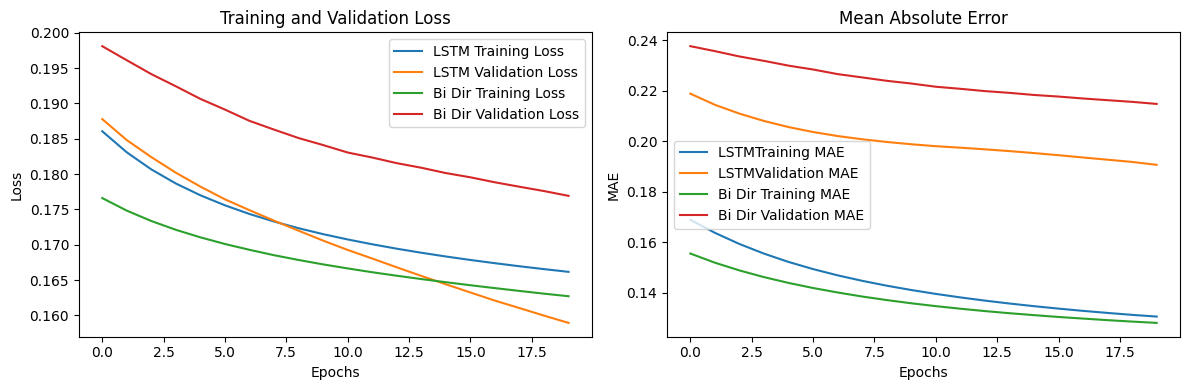

In [121]:
compare_models(best_history, best_history, "LSTM", "Bi Dir")

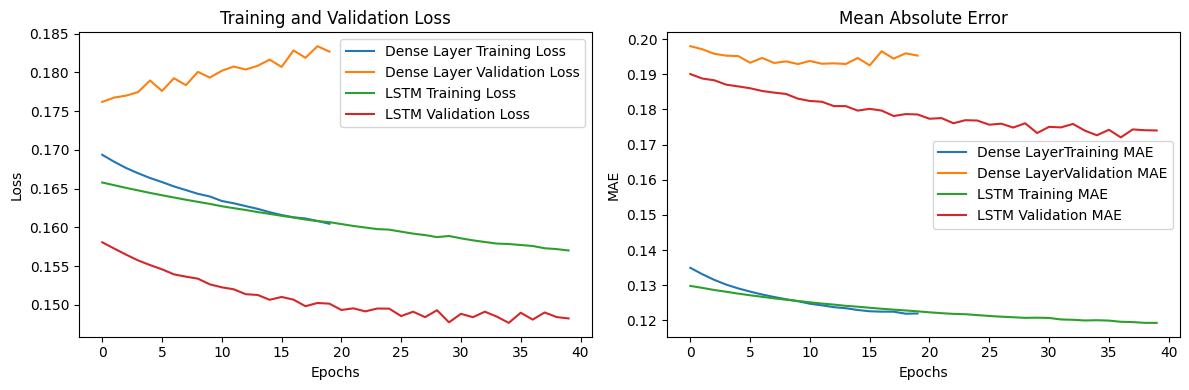

In [126]:
compare_models(best_simple_history, best_history, "Dense Layer", "LSTM")

In [118]:
# Rebuild the model and load weights from the best model no lstm
best_dense_model = build_best_model(tuner)

In [ ]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
best_dense_history = best_dense_model.fit(
    train_dataset,
    epochs=40,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

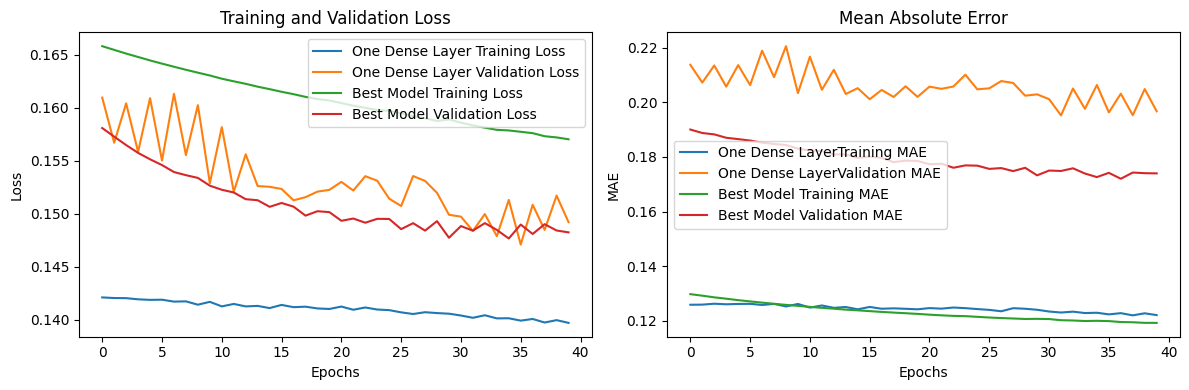

In [130]:
compare_models(best_dense_history, best_history, "One Dense Layer", "Best Model")

# Bi Directional

In [74]:
# Best hyperparameters
best_bi_hps = bi_tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for key, value in best_bi_hps.values.items():
    print(f"{key}: {value}")

Best hyperparameters:
lstm_units: 96
dense_units: 64
learning_rate: 0.0005844956795537632


In [76]:
# Rebuild the model and load weights from the best model
best_bi_model = build_best_bi_model(tuner)

In [ ]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
best_bi_history = best_bi_model.fit(
    train_dataset,
    epochs=40,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

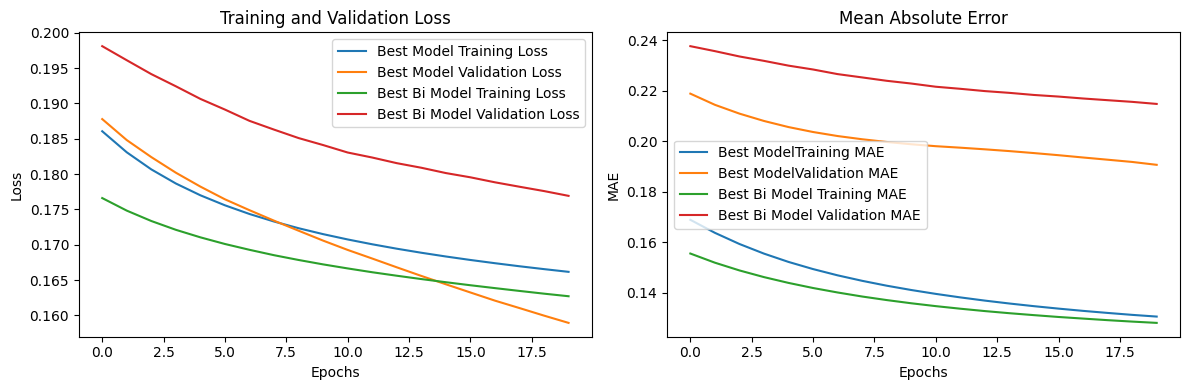

In [122]:
compare_models(best_history, best_bi_history, "Best Model", "Best Bi Model")

## Original Models

In [85]:
model = build_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 37)             │         1,887 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,487 (76.12 KB)

 Trainable params: 19,487 (76.12 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
bi_model = build_bi_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        35,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 37)             │         3,737 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,937 (152.10 KB)

 Trainable params: 38,937 (152.10 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
history = model.fit(
    train_dataset,
    epochs=20,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)


In [ ]:
# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
bi_history = bi_model.fit(
    train_dataset,
    epochs=20,
    #steps_per_epoch=bi_steps_per_epoch,
    validation_data=val_dataset
)



In [46]:
#history_dict['val_mae']

[0.30992981791496277,
 0.3008570373058319,
 0.28729987144470215,
 0.2620809078216553,
 0.2625470459461212,
 0.269218385219574,
 0.2402947098016739,
 0.24070829153060913,
 0.26532796025276184,
 0.2421676367521286,
 0.24359402060508728,
 0.2437315434217453,
 0.24171429872512817,
 0.261157363653183,
 0.252514123916626]

In [44]:
#history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

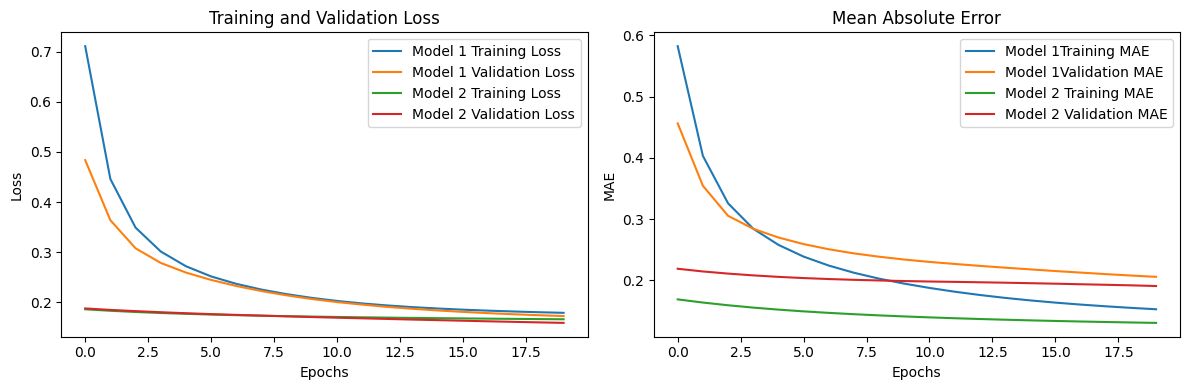

In [89]:
compare_models(history, best_history)

In [36]:
def compare_models(history_1, history_2, history_1_name="Model 1", history_2_name="Model 2"):  
    
    # Assuming `history` is the output from model.fit()
    
    history_1_dict = history_1.history
    history_2_dict = history_2.history
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_1_dict['loss'], label=f'{history_1_name} Training Loss')
    if 'val_loss' in history_1_dict:
        plt.plot(history_1_dict['val_loss'], label=f'{history_1_name} Validation Loss')
        
    plt.plot(history_2_dict['loss'], label=f'{history_2_name} Training Loss')
    if 'val_loss' in history_2_dict:
        plt.plot(history_2_dict['val_loss'], label=f'{history_2_name} Validation Loss')
        
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy (if available)
    plt.subplot(1, 2, 2)
    
    if 'mae' in history_1_dict:
        plt.plot(history_1_dict['mae'], label=f'{history_1_name}Training MAE')
    if 'val_mae' in history_1_dict:
        plt.plot(history_1_dict['val_mae'], label=f'{history_1_name}Validation MAE')
     
    if 'mae' in history_2_dict:
        plt.plot(history_2_dict['mae'], label=f'{history_2_name} Training MAE')
    if 'val_mae' in history_2_dict:
        plt.plot(history_2_dict['val_mae'], label=f'{history_2_name} Validation MAE')  
    
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    
    # Show the plots
    plt.tight_layout()
    plt.show()


In [16]:
model.save('swat_lstm_100s.keras')

# Open Saved Model

In [159]:
# Load the model from the SavedModel directory
# 20 secs
#swat_lstm = tf.keras.models.load_model('swat_lstm_1_0.keras')
swat_lstm = tf.keras.models.load_model('best_model_20.keras')
model_window = 20
#swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')
#model_window = 100

In [160]:
# Reshape the input from data_array to add the batch dimension
reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 19, 37)

# Make predictions
predictions = swat_lstm.predict(reshaped_input)

# Print predictions
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[-0.10063041  0.930967    0.46276343  1.0076933   0.73962754  0.08162647
   0.54213244  0.9903958   1.0700121   0.9697982   0.03650855  0.93601876
   0.96183413 -0.03231824  0.5463561   0.9871576   0.4909938   0.5637
  -0.01276371  1.086202    0.09962502  0.7296872   0.51459545  0.26292938
   0.4467907   0.64470464  0.69240767  0.77055097  0.5393644   0.51531476
   0.37834448  0.4602999   0.3447511   0.05375426  0.32186234  0.00652781
   0.03062825]]


In [161]:
actual = data_array[model_window-1:model_window, :]

In [162]:
reshaped_input.shape

(1, 19, 37)

In [163]:
actual

array([[0.        , 0.96908448, 0.5       , 1.        , 0.93559512,
        0.11540116, 0.55195725, 0.99907273, 1.        , 1.        ,
        0.        , 0.97655405, 0.93557469, 0.01052475, 0.5       ,
        1.        , 0.5       , 0.5       , 0.        , 1.        ,
        0.        , 0.78861569, 0.60121598, 0.18902553, 0.46262323,
        0.8117316 , 0.65201404, 0.76470648, 0.56394729, 0.55147743,
        0.2982467 , 0.24369638, 0.41468051, 0.23880613, 0.40000602,
        0.        , 0.        ]])

In [164]:
difference = actual - predictions

# Print results
print("Predictions:\n", predictions)
print("Actual Values:\n", actual)
print("Difference:\n", difference)

Predictions:
 [[-0.10063041  0.930967    0.46276343  1.0076933   0.73962754  0.08162647
   0.54213244  0.9903958   1.0700121   0.9697982   0.03650855  0.93601876
   0.96183413 -0.03231824  0.5463561   0.9871576   0.4909938   0.5637
  -0.01276371  1.086202    0.09962502  0.7296872   0.51459545  0.26292938
   0.4467907   0.64470464  0.69240767  0.77055097  0.5393644   0.51531476
   0.37834448  0.4602999   0.3447511   0.05375426  0.32186234  0.00652781
   0.03062825]]
Actual Values:
 [[0.         0.96908448 0.5        1.         0.93559512 0.11540116
  0.55195725 0.99907273 1.         1.         0.         0.97655405
  0.93557469 0.01052475 0.5        1.         0.5        0.5
  0.         1.         0.         0.78861569 0.60121598 0.18902553
  0.46262323 0.8117316  0.65201404 0.76470648 0.56394729 0.55147743
  0.2982467  0.24369638 0.41468051 0.23880613 0.40000602 0.
  0.        ]]
Difference:
 [[ 0.10063041  0.0381175   0.03723657 -0.00769329  0.19596758  0.03377469
   0.00982481  0.00

In [165]:
type(difference_list)

NameError: name 'difference_list' is not defined

# Predict Whole Dataset

In [166]:
split_time = int(data_array.shape[0] * 0.8)

val_dataset = data_array[split_time:]
##predict first 100 
predict_dataset = val_dataset[:1200]

In [167]:
#predict_dataset

In [168]:
#len(val_dataset)

In [169]:
predict_dataset.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [170]:
predict_dataset.shape

(1200, 37)

In [171]:
# Define a list to hold all predictions
all_predictions = []

# Loop through the dataset and predict step by step
for i in range(len(predict_dataset) - model_window + 1):
    # Extract the window of input data for prediction
    input_window = predict_dataset[i:i+model_window-1, :].reshape(1, model_window-1, data_array.shape[1])
    
    # Predict the next timestep
    predicted = swat_lstm.predict(input_window)
    
    # Save the prediction
    all_predictions.append(predicted[0])

# Convert predictions list to numpy array
all_predictions = np.array(all_predictions)

# Get the actual data for comparison (the next step in each window)
actual_data = predict_dataset[model_window-1:, :]  # All rows starting from model_window-1


# Optionally, you can calculate some error metrics
mae = np.mean(np.abs(all_predictions - actual_data))
print(f"Mean Absolute Error: {mae}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [172]:
type(all_predictions)

numpy.ndarray

In [173]:
all_predictions.shape

(1181, 37)

In [174]:
df_predictions = pd.DataFrame(all_predictions, columns=component_map)
df_predictions.info

<bound method DataFrame.info of         FIT101    LIT101     MV101      P101    AIT201    AIT202    AIT203  \
0     0.945588  0.468157  0.988345  0.004940  0.061099  0.128450  0.014435   
1     0.944244  0.471219  0.987434  0.003213  0.062053  0.128316  0.015507   
2     0.940940  0.474390  0.986947  0.001795  0.063827  0.130326  0.015854   
3     0.938020  0.477786  0.985636  0.001222  0.065219  0.130900  0.017729   
4     0.935885  0.480518  0.984717  0.000846  0.066131  0.131448  0.019158   
...        ...       ...       ...       ...       ...       ...       ...   
1176 -0.021925  0.520631  0.483451  1.005409  0.073513 -0.010009  0.086123   
1177 -0.022994  0.519008  0.482944  1.006940  0.073257 -0.010031  0.085967   
1178 -0.024391  0.517378  0.482970  1.007625  0.073189 -0.008542  0.084572   
1179 -0.025105  0.516533  0.482958  1.008441  0.073241 -0.008053  0.083878   
1180 -0.025689  0.515531  0.484216  1.007258  0.072820 -0.010071  0.084221   

        FIT201     MV201      P

In [175]:
predict_dataset = predict_dataset[window_size-1:]

In [176]:
df_actual = pd.DataFrame(predict_dataset, columns=component_map)
df_actual.info

<bound method DataFrame.info of         FIT101    LIT101  MV101  P101    AIT201    AIT202    AIT203    FIT201  \
0     0.948097  0.484542    1.0   0.0  0.061020  0.129231  0.024717  0.000000   
1     0.943682  0.486564    1.0   0.0  0.061020  0.133999  0.024717  0.000000   
2     0.936523  0.487872    1.0   0.0  0.061020  0.133999  0.024717  0.000000   
3     0.930915  0.488109    1.0   0.0  0.061020  0.133999  0.024717  0.000000   
4     0.924472  0.490844    1.0   0.0  0.061020  0.133999  0.024717  0.000000   
...        ...       ...    ...   ...       ...       ...       ...       ...   
1176  0.000000  0.509988    0.5   1.0  0.040676  0.022411  0.093826  0.982950   
1177  0.000000  0.508324    0.5   1.0  0.040676  0.022411  0.093523  0.983156   
1178  0.000000  0.508324    0.5   1.0  0.040676  0.022411  0.093523  0.983156   
1179  0.000000  0.506421    0.5   1.0  0.040676  0.022411  0.093422  0.983980   
1180  0.000000  0.505232    0.5   1.0  0.040676  0.022411  0.092514  0.983980

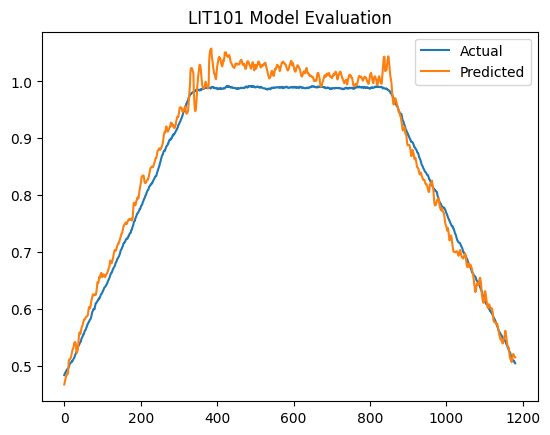

Mean Absolute Error: 0.022430190524471514


In [177]:
plt.plot(df_actual['LIT101'], label='Actual')
plt.plot(df_predictions['LIT101'], label='Predicted')

plt.title('LIT101 Model Evaluation')
plt.legend()
plt.show()
mae = np.mean(np.abs(df_predictions['LIT101'] - df_actual['LIT101']))
print(f"Mean Absolute Error: {mae}")

In [38]:
# Assuming `history` is the output from model.fit()

history_1_dict = best_history.history


# Plot training & validation loss
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)

if 'mae' in history_1_dict:
    plt.plot(history_1_dict['mae'], label='Train MAE')
if 'val_mae' in history_1_dict:
    plt.plot(history_1_dict['val_mae'], label='Val MAE')
    
if 'loss' in history_1_dict:
    plt.plot(history_1_dict['loss'], label='Train Loss')
if 'val_loss' in history_1_dict:
    plt.plot(history_1_dict['val_loss'], label='Val Loss')
        
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(ncol=2)

# Plot accuracy (if available)
plt.subplot(1, 2, 2)

plt.plot(df_actual['LIT101'], label='Actual')
plt.plot(df_predictions['LIT101'], label='Predicted')

mae = np.mean(np.abs(df_predictions['LIT101'] - df_actual['LIT101']))
plt.legend([f'LIT101 Actual', f'Predicted (MAE: {mae:.4f})'])


plt.xlabel('Seconds')
plt.ylabel('Scaled Value')

# Show the plots
#plt.tight_layout()

# Save the plot to a file (e.g., "plot.png")
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/LSTM_Eval.jpeg')
plt.show()

NameError: name 'best_history' is not defined

# Train Agent

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [ ]:
print('test')